# Transfer MobileNet

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Local Train / Test set paths

In [44]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../../raw_data_original/SAMPLES/TRAIN_5K'
local_test_path = '../../raw_data_original/SAMPLES/TEST_5K'

## Cloud paths - TO DO

In [45]:
# Need to link to cloud storage account hosting all sample folders already ready to use by the model
cloud_train_path = '..'
cloud_test_path = '..'

## Preprocessing - Loading Train & Test images as Tensorflow generators

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input

In [47]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#preprocessing_function=preprocess_input

In [52]:
# Load from directory to flow passsed into ImageGenerator
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    batch_size=16,
                                                    target_size=(96,96),
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  batch_size=16,
                                                  target_size=(96,96),
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [53]:
img_path = '../raw_data/TEST/1/0a1b615eacd80e7a9a8ba9991c04f1453bd4556b.tif'

In [54]:
img_generator = test_datagen.flow(img_path)
                                             

ValueError: could not convert string to float: '../raw_data/TEST/1/0a1b615eacd80e7a9a8ba9991c04f1453bd4556b.tif'

In [55]:
train_generator[0][0][0][0]
#/Users/chloeguillaume/code/GuillaumeRib/project-cancer-detection/raw_data/TEST/1/0a1b615eacd80e7a9a8ba9991c04f1453bd4556b.tif

array([[ 0.19215691, -0.58431375,  0.14509809],
       [ 0.39607847, -0.38039213,  0.34901965],
       [ 0.17647064, -0.6156863 ,  0.13725495],
       [ 0.35686278, -0.44313723,  0.33333337],
       [ 0.22352946, -0.6       ,  0.19215691],
       [ 0.39607847, -0.40392154,  0.3803922 ],
       [ 0.20784318, -0.5764706 ,  0.20000005],
       [ 0.4431373 , -0.3098039 ,  0.45882356],
       [ 0.36470592, -0.3490196 ,  0.39607847],
       [ 0.10588241, -0.5764706 ,  0.16078436],
       [ 0.30196083, -0.36470586,  0.36470592],
       [ 0.20000005, -0.46666664,  0.26274514],
       [ 0.30980396, -0.35686272,  0.37254906],
       [ 0.4431373 , -0.25490195,  0.48235297],
       [ 0.6627451 , -0.05098039,  0.7019608 ],
       [ 0.5058824 , -0.23137254,  0.5294118 ],
       [ 0.1686275 , -0.5764706 ,  0.20784318],
       [ 0.3176471 , -0.4352941 ,  0.34901965],
       [ 0.20784318, -0.56078434,  0.24705887],
       [ 0.2941177 , -0.47450978,  0.33333337],
       [ 0.3803922 , -0.36470586,  0.450

## Model Import - Transfer Learning

In [56]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers, models

def load_model():
    model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape =(96,96,3))
    return model


def set_nontrainable_layers(model):
    model.trainable = False
    return model


def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
   
    base_model = set_nontrainable_layers(model)
    pooling_layer = layers.GlobalAveragePooling2D()
    flatten_layer = layers.Flatten()
    dense_layer_100 = layers.Dense(100, activation='relu')
    dense_layer_40 = layers.Dense(40, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')
    dropout_layer = layers.Dropout(rate=0.20)
    
    model = models.Sequential([
        base_model,
        pooling_layer,
        flatten_layer,
        dense_layer_100,
        dropout_layer,
        dense_layer_40,
        prediction_layer
    ])
    return model

### Build the model

In [57]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

def build_model():
    model = load_model()
    model = add_last_layers(model)

    optim = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

In [58]:
model = build_model()
model.summary()

2022-09-15 07:40:34.374056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                4

### Model Training

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
# Fitting the model using VGG16 first layers
model = build_model()
epochs = 1
batch_size = 16
es = EarlyStopping(patience=5, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

250/250 [==============================] - 273s 1s/step - loss: 0.4956 - accuracy: 0.7707 - val_loss: 0.4154 - val_accuracy: 0.8160


### Plot Loss & Accuracy charts FUNCTION

In [ ]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

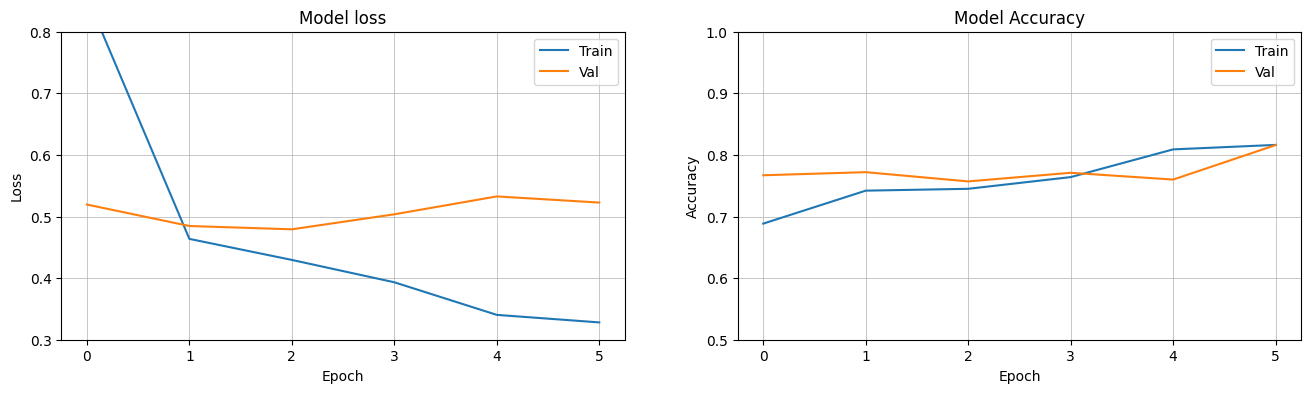

In [15]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

### Model Evaluation

In [67]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

32/32 [==============================] - 46s 1s/step - loss: 0.3970 - accuracy: 0.8350
The accuracy on the test set is of 83.50 %


In [68]:
y_pred = model.predict(test_generator)

32/32 [==============================] - 45s 1s/step


In [91]:
y_pred[0:25]

array([[0.13783683, 0.8621632 ],
       [0.15217006, 0.8478299 ],
       [0.82537794, 0.17462206],
       [0.6942889 , 0.3057111 ],
       [0.32875517, 0.67124486],
       [0.600618  , 0.399382  ],
       [0.54699653, 0.4530034 ],
       [0.06345496, 0.9365451 ],
       [0.8584053 , 0.14159465],
       [0.7821901 , 0.2178099 ],
       [0.18519597, 0.814804  ],
       [0.78233147, 0.21766852],
       [0.08901811, 0.9109819 ],
       [0.6250778 , 0.37492222],
       [0.34819973, 0.6518003 ],
       [0.04853448, 0.9514655 ],
       [0.24008921, 0.75991076],
       [0.35214877, 0.6478512 ],
       [0.08217418, 0.9178259 ],
       [0.92662466, 0.07337531],
       [0.42310506, 0.576895  ],
       [0.7067966 , 0.29320347],
       [0.15529062, 0.8447094 ],
       [0.7430734 , 0.25692654],
       [0.6174053 , 0.38259473]], dtype=float32)

In [69]:
import tensorflow as tf
predicted_categories = tf.argmax(y_pred, axis=1)

In [92]:
predicted_categories[0:25]

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0])>

In [106]:
from tensorflow.math import confusion_matrix
conf_mat = confusion_matrix(    
    test_generator.classes,
    predicted_categories,
    num_classes=2,
    weights=None,
    name=None
)

In [75]:
conf_mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[335, 255],
       [230, 180]], dtype=int32)>

In [93]:
from tensorflow import metrics

In [87]:
metrics.AUC()

In [59]:
kernel_test= model.layers[0].weights[0][:,:, 0, 10]

In [60]:
kernel_test

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-0.03573126, -0.06283543, -0.01060865],
       [ 0.02219751, -0.02285688, -0.06532077],
       [ 0.3784709 ,  0.14523017, -0.0334829 ]], dtype=float32)>

In [68]:
def compute_convolution(img, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(img) # Removes dimensions of size 1
    img_height, img_width = img.shape
    
    array = []

    for x in range(img_height - kernel_height + 1):
        arr = []
        
        for y in range(img_width - kernel_width + 1):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width], kernel)
            arr.append(a.sum())
            
        array.append(arr)
        
    return array

In [61]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [62]:
img_0 = '../../raw_data_original/SAMPLES/TRAIN_5K/0/0a9b8d6a7cd78c8fc3723eca9e390032c1f26ef1.tif'

In [63]:
from PIL import Image

In [121]:
img = Image.open(img_0)
img_nb = img.convert('LA')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


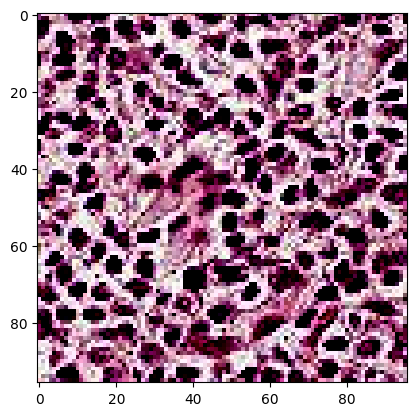

In [141]:
import numpy as np
img_np = np.array(img)

from keras.applications.mobilenet_v2 import preprocess_input
img_preproc = preprocess_input(img_np)
from matplotlib import pyplot as plt
plt.imshow(img_preproc, interpolation='nearest',)
plt.show()

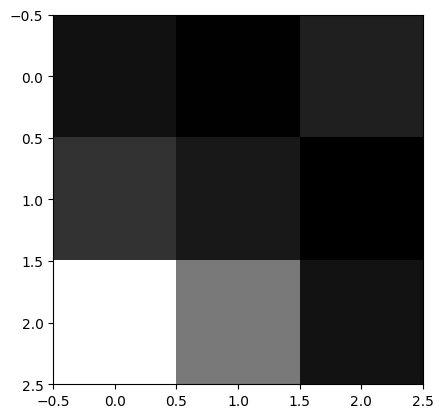

In [138]:
kernel_0 = np.array(model.layers[0].weights[0][:,:, 0, 10])
plt.imshow(kernel_0, interpolation='nearest',cmap='gray')
plt.show()

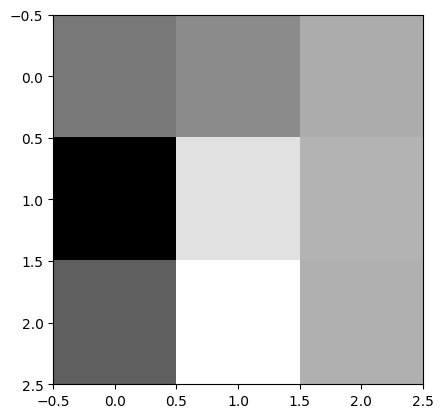

In [139]:
kernel_1 = np.array(model.layers[0].weights[0][:,:, 2, 2])
plt.imshow(kernel_1, interpolation='nearest',cmap='gray')
plt.show()

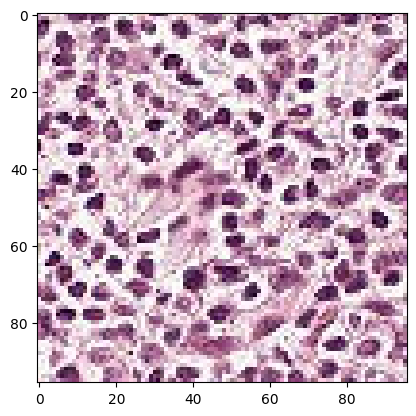

In [144]:
plt.imshow(img_nb_np, interpolation='nearest',)
plt.show()

In [145]:
img_nb_np.shape

(96, 96, 3)

In [175]:
img_np_nb = np.delete(img_np, -1, axis=2)
img_np_nb= np.delete(img_np_nb, -1, axis=2)
img_np_nb= np.delete(img_np_nb, -1, axis=2)
img_np_nb.shape


(96, 96, 0)

In [176]:
plot_convolution(img_np_nb,kernel_1,activation=True)

ValueError: too many values to unpack (expected 2)